# Assignment 4: Spam classification using Naïve Bayes

**Submitted by:** *Neha Devi Shakya 13h, Sarvesh Meenowa 13h*

There will be an overall grade for this assignment. To get a pass grade (grade 3), you need to pass items 1-3 below. To receive higher grades, finish items 4 and 5 as well.

In this assignment you will implement a Naïve Bayes classifier in Python that will classify emails into spam and non-spam (“ham”) classes. Your program should be able to train on a given set of spam and “ham” datasets.

You will work with the datasets available at https://spamassassin.apache.org/old/publiccorpus/. There are three types of files in this location: 
* easy-ham: non-spam messages typically quite easy to differentiate from spam messages. 
* hard-ham: non-spam messages more difficult to differentiate
* spam: spam messages

There are multiple folders for each category, download at least the first three, but results will be more stable the more data you have for each category. Read the “readme.html” for a full description of the file contents. 

The .bz2-file can be unzipped using the linux command

        tar –xjvf file.bz2

which will result in a directory named “file”, containing all email messages as separate files. I suggest you uncompressed the files before trying to lead them into Python.


## 1.	Preprocessing: 
Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text. Further down (in the higher-grade part), you will be asked to filter out the headers and footers. 


In [1]:
#import all packages
import email

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, 
                             classification_report, confusion_matrix,
                             plot_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### a. Load the text data into your Python program. Hint: look at the documentation for the sklearn.datasets.load_files function. Hint 2: use encoding = ”latin-1”. Investigate how many emails are in each category and note this in your report.

**We decided to include the emails from all the forlders given in the link ([spamassassin.apache.org/old/publiccorpus/](https://spamassassin.apache.org/old/publiccorpus/)).**

In [ ]:
import zipfile
with zipfile.ZipFile("data/data.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [2]:
# use sklearn load_files to have data on easy ham vs spam
emails_easy_spam = load_files("data/raw/easy_ham_vs_spam_data/", encoding = "latin-1")

# use sklearn load_files to have data on hard ham vs spam
emails_hard_spam = load_files("data/raw/hard_ham_vs_spam_data/", encoding="latin-1")

In [3]:
np.bincount(emails_easy_spam.target)

array([6452, 2399], dtype=int64)

In [4]:
np.bincount(emails_hard_spam.target)

array([ 501, 2399], dtype=int64)

|   Esay Ham    |   Hard Ham    |   Spam    |
|     :----:    |     :----:    |   :----:  |
|     6452      |      501      |   2399    |

### b. We don’t want to train and test on the same data. Split the spam and the ham datasets in a training set and a test set. Hint: look at the documentation for sklearn’s train_test_split() function.

In [5]:
# split the spam and the ham datasets in a training set and a test set.
x_easy_spam_train, x_easy_spam_test, y_easy_spam_train, y_easy_spam_test = train_test_split(emails_easy_spam.data, emails_easy_spam.target, test_size = 0.2, random_state = 0)
x_hard_spam_train, x_hard_spam_test, y_hard_spam_train, y_hard_spam_test = train_test_split(emails_hard_spam.data, emails_hard_spam.target, test_size = 0.2, random_state = 0)

## 2. For this question you will write a function in Python with the following name and arguments:  
    def run_naiveBayes(ham_train, ham_test, spam_train, spam_test):

### Naive Bayes Classification Function

In [6]:
def run_naiveBayes(ham_train, ham_test, spam_train, spam_test, model_name):
    if model_name == "MultinomialNB":
        # Transform the data into vectors with CountVectorizer
        CV = CountVectorizer()
        x_train = CV.fit_transform(ham_train)
        x_test = CV.transform(ham_test)
        y_train = spam_train.astype("int")

        # Train the MultinomialNB classifier
        model = MultinomialNB().fit(x_train, y_train)
            
    elif model_name == "BernoulliNB":
        # Transform the data into vectors with CountVectorizer with binary = True
        CV = CountVectorizer(binary = True)
        x_train = CV.fit_transform(ham_train)
        x_test = CV.transform(ham_test)
        y_train = spam_train.astype("int")
        
        # Train the BernouilliNB classifier
        model = BernoulliNB().fit(x_train, y_train)

    # predict spam or ham
    y_pred = model.predict(x_test)
    # calculate accuracy score
    acc = accuracy_score(spam_test, y_pred)
    # create confusion matrix
    cm = confusion_matrix(spam_test, y_pred)
    # create classification report
    cr = classification_report(spam_test,y_pred)

    return acc, cm, cr

### Discuss the differences between Multinomial Naive Bayes and Bernouilli Naive Bayes

The Bernoulli Naive Nayes classifier performs the classifications of the emails based on words(features) occuring or not. In general,it treats features(words) as binary values whereas the Multinomial Naive Bayes classifier calculates the frequency with which a feature(a word in context of this classification) appears.

For instance, if we take two snippets of two emails :
* Text 1 : "Invest in crypto crypto crypto"
* Text 2 : "Invest in crypto"

Bernoulli NB would classify Text 1 and Text 2 similarly since it checks if the feature "crypto" is there but doesn't account for the frequency, which Multinomial NB will account for. The way the classifiers work differs, which has an impact on how well they perform. From the preceding example, it is plausible explanation why the multinomial classifier outperforms the bernoulli classifier as we see later in part 3.

## 3. Run the function you wrote in the previous question on

In [7]:
def plot_cfm(cfm, acc, model_name: str, tick_labels: list):
    # set plot size
    plt.figure(figsize = (15, 10))

    fig = sns.heatmap(cfm, annot = True, fmt = "d", linewidths = .5, square = True, cmap = "Blues_r")

    # add plot title and axis labels
    all_sample_title = f"Confusion Matrix for {model_name} classification \n\n Accuracy Score: {round(acc, 3)}"
    fig.set_title(all_sample_title, size = 15)
    fig.set_xlabel("Predicted label")
    fig.set_ylabel("Actual label")
    fig.xaxis.set_ticklabels(tick_labels)
    fig.yaxis.set_ticklabels(tick_labels)
    plt.show()

### i.	Spam versus easy-ham

#### Multinomial Naive Bayes

In [8]:
acc_easy_mnb, cfm_easy_mnb, cr_easy_mnb = run_naiveBayes(x_easy_spam_train, x_easy_spam_test, y_easy_spam_train, y_easy_spam_test, "MultinomialNB")

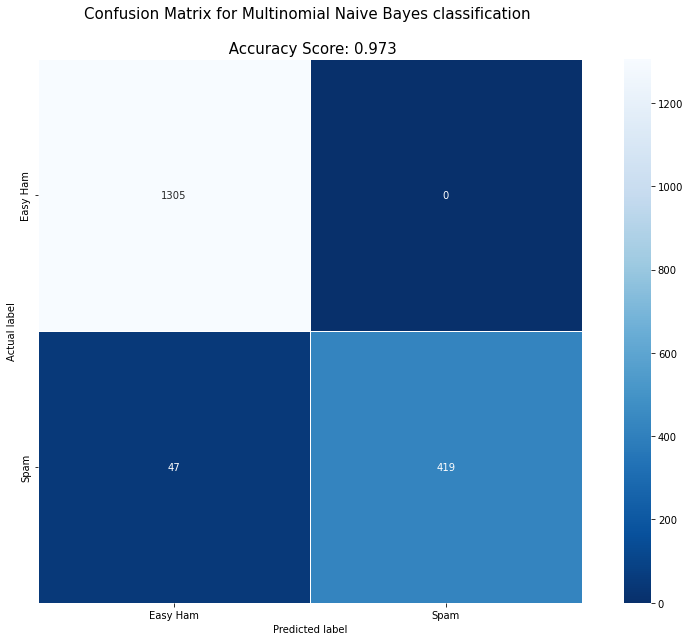

In [9]:
plot_cfm(cfm_easy_mnb, acc_easy_mnb, "Multinomial Naive Bayes", ["Easy Ham", "Spam"])

In [10]:
print(cr_easy_mnb)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1305
           1       1.00      0.90      0.95       466

    accuracy                           0.97      1771
   macro avg       0.98      0.95      0.96      1771
weighted avg       0.97      0.97      0.97      1771



### Why is only reporting accuracy not a good idea in this case? 

With the Multinomial Naive Bayes classifier, we obtained an accuracy of 0.97 when classifying easy ham and spam. However, the value of this accuracy may be misleading since the classification accuracy fails on classification problems with a skewed class distribution(more hams than spams), which means we have to use other evaluation metrics such as precision and recall.

To obtain precision and recall, we use the classification report function from sklearn. We consider the precision and recall for the positive class, i.e. spam. The precision is very high at 1.00, which means it has no false positives i.e. there are no actual hams are classified as spams. The model has lower recall which means that it has more false negatives(FN = 47), i.e. spams are misclassified as hams. There is a trade-off between precision and recall. However, to know which one (precision or recall) we want to be higher depends on the context and which one would consider worse, having more spams classified as hams or more hams classified as spams.

#### Bernouilli Naive Bayes


In [11]:
acc_easy_bnb, cfm_easy_bnb, cr_easy_bnb = run_naiveBayes(x_easy_spam_train, x_easy_spam_test, y_easy_spam_train, y_easy_spam_test, "BernoulliNB")

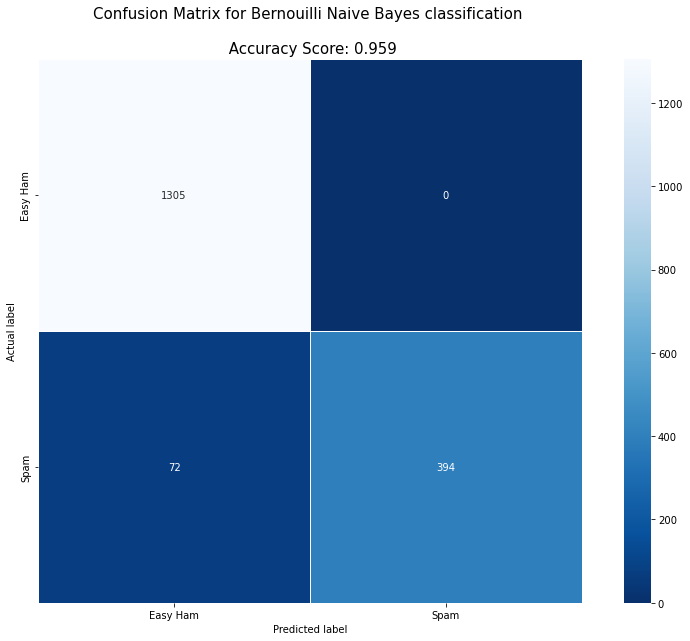

In [12]:
plot_cfm(cfm_easy_bnb, acc_easy_bnb, "Bernouilli Naive Bayes", ["Easy Ham", "Spam"])

In [13]:
print(cr_easy_bnb)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1305
           1       1.00      0.85      0.92       466

    accuracy                           0.96      1771
   macro avg       0.97      0.92      0.94      1771
weighted avg       0.96      0.96      0.96      1771



### Why is only reporting accuracy not a good idea in this case? 

Despite having a relatively high accuracy (0.96), the Bernoulli NB classifier has a relatively low recall for the positive class, i.e. spam; that is, it has a high number of false-negative (FN = 72), i.e. spams are misclassified as easy hams.

### ii Spam versus hard-ham

#### Multinomial Naive Bayes

In [14]:
acc_hard_mnb, cfm_hard_mnb, cr_hard_mnb = run_naiveBayes(x_hard_spam_train, x_hard_spam_test, y_hard_spam_train, y_hard_spam_test, "MultinomialNB")

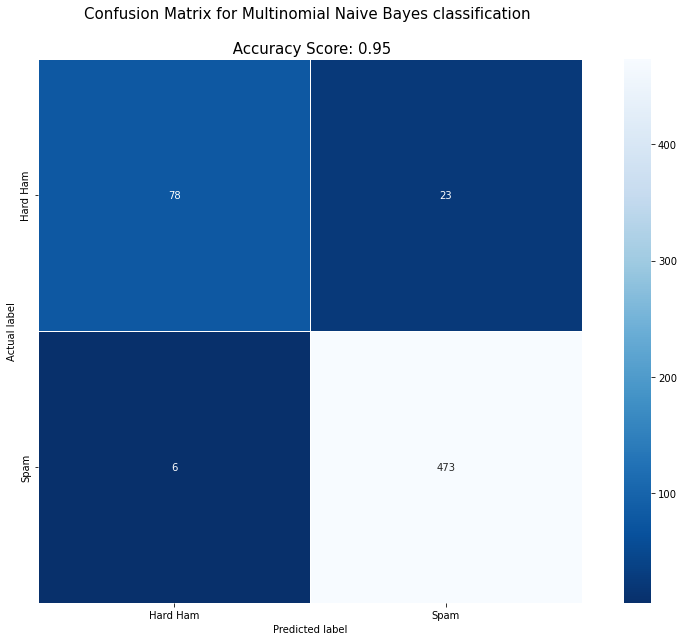

In [15]:
plot_cfm(cfm_hard_mnb, acc_hard_mnb, "Multinomial Naive Bayes", ["Hard Ham", "Spam"])

In [16]:
print(cr_hard_mnb)

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       101
           1       0.95      0.99      0.97       479

    accuracy                           0.95       580
   macro avg       0.94      0.88      0.91       580
weighted avg       0.95      0.95      0.95       580



Multinomial Naive Bayes performs well accuracy wise (0.95) and has both precision and recall close to 1, which is the ideal scenario in the classification of hard ham and spam. This time the accuracy score is closer to the f1-score (or precision/recall) since the dataset is less imbalanced than easy ham and spam.

#### Bernoulli Naive Bayes

In [17]:
acc_hard_bnb, cfm_hard_bnb, cr_hard_bnb = run_naiveBayes(x_hard_spam_train, x_hard_spam_test, y_hard_spam_train, y_hard_spam_test, "BernoulliNB")

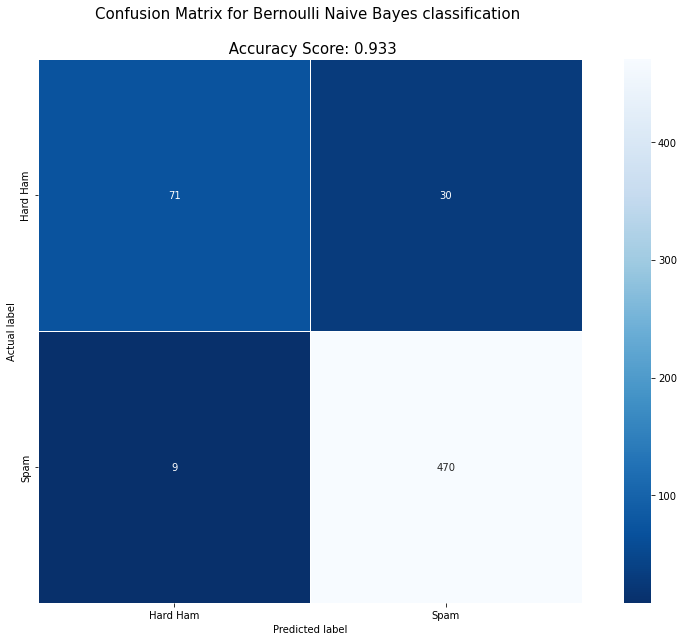

In [18]:
plot_cfm(cfm_hard_bnb, acc_hard_bnb, "Bernoulli Naive Bayes", ["Hard Ham", "Spam"])

In [19]:
print(cr_hard_bnb)

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       101
           1       0.94      0.98      0.96       479

    accuracy                           0.93       580
   macro avg       0.91      0.84      0.87       580
weighted avg       0.93      0.93      0.93       580



Bernoulli NB has an accuracy of 0.93 in hard ham and spam classification. The model has a very high recall and lower precision, meaning it has more false positives, i.e. it misclassifies hard hams as spams. 

<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow" rowspan="3">Classifier</th>
    <th class="tg-c3ow" rowspan="3">Ham Type</th>
    <th class="tg-c3ow" colspan="7">Part 3</th>
  </tr>
  <tr>
    <th class="tg-c3ow" rowspan="2">accuracy</th>
    <th class="tg-c3ow" colspan="2">precision</th>
    <th class="tg-c3ow" colspan="2">recall</th>
    <th class="tg-c3ow" colspan="2">f1-score</th>
  </tr>
  <tr>
    <th class="tg-c3ow">0</th>
    <th class="tg-c3ow">1</th>
    <th class="tg-c3ow">0</th>
    <th class="tg-c3ow">1</th>
    <th class="tg-c3ow">0</th>
    <th class="tg-c3ow">1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow" rowspan="2">Multinomial Naive Bayes</td>
    <td class="tg-c3ow">Easy</td>
    <td class="tg-c3ow">0.97</td>
    <td class="tg-c3ow">0.97</td>
    <td class="tg-c3ow">1.00</td>
    <td class="tg-c3ow">1.00</td>
    <td class="tg-c3ow">0.90</td>
    <td class="tg-c3ow">0.98</td>
    <td class="tg-c3ow">0.95</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Hard</td>
    <td class="tg-c3ow">0.95</td>
    <td class="tg-c3ow">0.93</td>
    <td class="tg-c3ow">0.95</td>
    <td class="tg-c3ow">0.77</td>
    <td class="tg-c3ow">0.99</td>
    <td class="tg-c3ow">0.84</td>
    <td class="tg-c3ow">0.97</td>
  </tr>
  <tr>
    <td class="tg-c3ow" rowspan="2">Bernoulli Naive Bayes</td>
    <td class="tg-c3ow">Easy</td>
    <td class="tg-c3ow">0.96</td>
    <td class="tg-c3ow">0.95</td>
    <td class="tg-c3ow">1.00</td>
    <td class="tg-c3ow">1.00</td>
    <td class="tg-c3ow">0.85</td>
    <td class="tg-c3ow">0.97</td>
    <td class="tg-c3ow">0.92</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Hard</td>
    <td class="tg-c3ow">0.93</td>
    <td class="tg-c3ow">0.89</td>
    <td class="tg-c3ow">0.94</td>
    <td class="tg-c3ow">0.70</td>
    <td class="tg-c3ow">0.98</td>
    <td class="tg-c3ow">0.78</td>
    <td class="tg-c3ow">0.96</td>
  </tr>
</tbody>
</table>

Overall, Multinomial Naive Bayes performs better than  Bernoulli Naive Bayes in classifying easy ham and hard ham versus spam, which was expected due to how the algorithms operate, as mentioned above.

## 4.	[For higher grades] To avoid classification based on common and uninformative words it is common to filter these out. 

### a.	Argue why this may be useful. Try finding the words that are too common/uncommon in the dataset. 

Those words are known as stopwords. They occur in abundance in any human language. Stopwords refer to the words in any language which does not add much meaning to a sentence. By removing the low-level information from our dataset, we can give more focus to the important information. As a result, removing stopwords may aid performance by reducing the number of tokens available to only the most important ones. Also, removing stopwords decreases the data size, and the training time also decreases with no discernible effect on the model "s accuracy.

While libraries such as NLTK and Spacey have a corpus of stopwords which generalizes common words used in different languages, it will remove words such as "the", "is", and "and". However, in sklearn, for CountVectorizer (which we will use in 3 (b), we have an in-built parameter to control stopwords because they either : 

 * occurred in too many documents (max_df)
 * occurred in too few documents (min_df)
 * were cut off by feature selection (max_features).
 
If we use the stop_words = "english" parameter in CountVectorize, sklearn acknowledges that there are several known issues with 'english' and considers an alternative such as using (min_df,max_df) = (0,0.7). In 3 (b), we tried for the CountVectorizer() with (min_df,max_df) = (0,0.7); however, if we want to optimize the model, we can perform hyperparameter tuning to obtain min_df and max_df values, which give better results in terms of precision, recall or f1-score.



In [20]:
# function to get the most frequent (common/uncommon) words in a given text corpus.
def get_frequent_words(corpus, order, n = None):
    vector = CountVectorizer().fit(corpus)
    bag_of_words = vector.transform(corpus)
    words_sum = bag_of_words.sum(axis = 0)
    words_frequency = [(word, words_sum [0, idx]) for word, idx in vector.vocabulary_.items()]
    
    if order.lower() == "common":
        words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse = True)
    elif order.lower() == "uncommon":
        words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse = False)
    
    return words_frequency[:n]

In [21]:
get_frequent_words(emails_easy_spam.data, "uncommon", 20)

[('4480043fb1', 1),
 ('g79hrpb17417', 1),
 ('31e4329410f', 1),
 ('4a7ed2940fc', 1),
 ('g79hhfg17946', 1),
 ('3d53f935', 1),
 ('2020704', 1),
 ('squick', 1),
 ('schmegma', 1),
 ('dork', 1),
 ('slithy', 1),
 ('mimsy', 1),
 ('gimble', 1),
 ('frumious', 1),
 ('bequeathed', 1),
 ('45f2f440cc', 1),
 ('g6njjj422662', 1),
 ('46433294109', 1),
 ('15116294106', 1),
 ('17x59z', 1)]

In [22]:
get_frequent_words(emails_easy_spam.data, "common", 20)

[('com', 117069),
 ('to', 94912),
 ('the', 89871),
 ('from', 77383),
 ('2002', 74106),
 ('net', 64461),
 ('for', 60798),
 ('with', 58247),
 ('by', 58003),
 ('3d', 55366),
 ('org', 53793),
 ('font', 53452),
 ('localhost', 51206),
 ('id', 50695),
 ('received', 49272),
 ('of', 47154),
 ('and', 46951),
 ('11', 40124),
 ('list', 39823),
 ('http', 35410)]

The most uncommon words were strings of numbers and letters i.e. meaningless words. Some most common words were com and net which could indicate the presence of links in the emails.

### b. Use the parameters in Sklearn’s CountVectorizer to filter out these words. Run the updated program on your data and record how the results differ from 3. You have two options to do this in Sklearn: either using the words found in part (a) or letting Sklearn do it for you

In [23]:
def run_naiveBayes_2(ham_train, ham_test, spam_train, spam_test,model_name):
    if model_name == "MultinomialNB":
        # Transform the data into vectors with CountVectorizer
        CV = CountVectorizer(max_df = 0.7, min_df = 0)
        x_train = CV.fit_transform(ham_train)
        x_test = CV.transform(ham_test)
        y_train = spam_train.astype("int")

        # Train the MultinomialNB classifier
        model = MultinomialNB().fit(x_train, y_train)
            
    elif model_name == "BernoulliNB":
        # Transform the data into vectors with CountVectorizer with binary = True
        CV = CountVectorizer(binary = True, max_df = 0.7, min_df = 0)
        x_train = CV.fit_transform(ham_train)
        x_test = CV.transform(ham_test)
        y_train = spam_train.astype("int")
        
        # Train the BernouilliNB classifier
        model = BernoulliNB().fit(x_train, y_train)

    # predict spam or ham
    y_pred = model.predict(x_test)
    # calculate accuracy score
    acc = accuracy_score(spam_test, y_pred)
    # create confusion matrix
    cm = confusion_matrix(spam_test, y_pred)
    # create classification report
    cr = classification_report(spam_test,y_pred)

    return acc, cm, cr

### i. Spam versus easy-ham

#### Multinomial Naive Bayes

In [24]:
acc_easy_mnb_2, cfm_easy_mnb_2, cr_easy_mnb_2 = run_naiveBayes_2(x_easy_spam_train, x_easy_spam_test, y_easy_spam_train, y_easy_spam_test, "MultinomialNB")

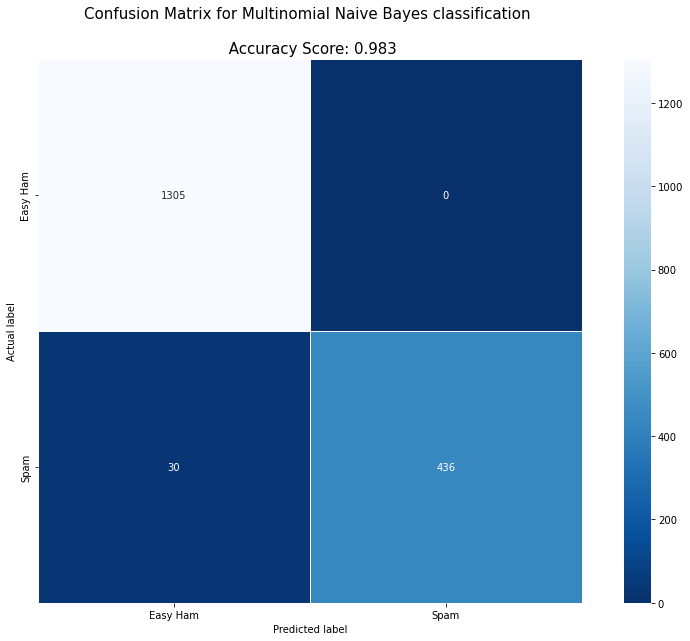

In [25]:
plot_cfm(cfm_easy_mnb_2, acc_easy_mnb_2, "Multinomial Naive Bayes", ["Easy Ham", "Spam"])

In [26]:
print(cr_easy_mnb_2)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1305
           1       1.00      0.94      0.97       466

    accuracy                           0.98      1771
   macro avg       0.99      0.97      0.98      1771
weighted avg       0.98      0.98      0.98      1771



With the Multinomial Naive Bayes classifier, we obtained an accuracy of 0.98 when classifying easy ham and spam.  We consider the precision and recall for the positive class, i.e. spam. The precision is at 1.00, which means it has no false positives that are actual hams are classified as spams. The model has lower recall which means that it has more false negatives(FN = 30), i.e. spams are misclassified as hams. 

#### Bernouilli Naive Bayes


In [27]:
acc_easy_bnb_2, cfm_easy_bnb_2, cr_easy_bnb_2 = run_naiveBayes_2(x_easy_spam_train, x_easy_spam_test, y_easy_spam_train, y_easy_spam_test, "BernoulliNB")

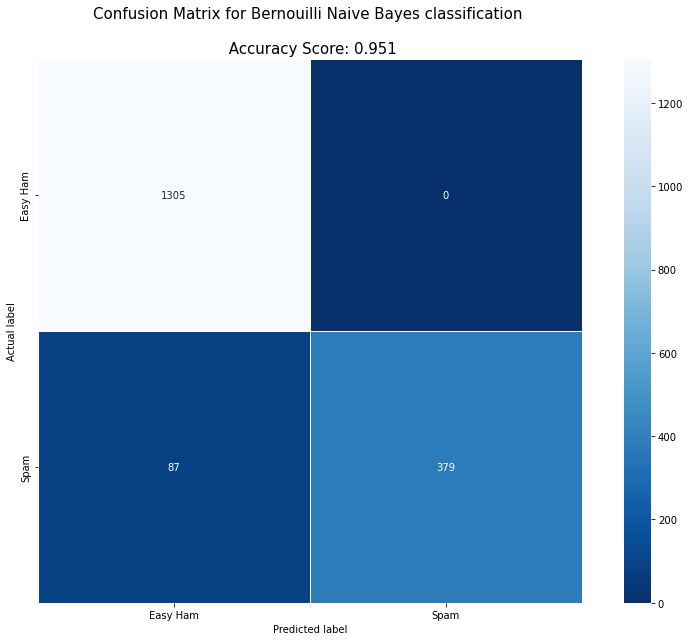

In [28]:
plot_cfm(cfm_easy_bnb_2, acc_easy_bnb_2, "Bernouilli Naive Bayes", ["Easy Ham", "Spam"])

In [29]:
print(cr_easy_bnb_2)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1305
           1       1.00      0.81      0.90       466

    accuracy                           0.95      1771
   macro avg       0.97      0.91      0.93      1771
weighted avg       0.95      0.95      0.95      1771



Despite having a relatively high accuracy (0.95), the Bernoulli NB classifier has a relatively low recall for the positive class, i.e. spam; that is, it has a high number of false-negative (FN = 87), i.e. spams are misclassified as easy hams.

### ii Spam versus hard-ham

#### Multinomial Naive Bayes

In [30]:
acc_hard_mnb_2, cfm_hard_mnb_2, cr_hard_mnb_2 = run_naiveBayes_2(x_hard_spam_train, x_hard_spam_test, y_hard_spam_train, y_hard_spam_test, "MultinomialNB")

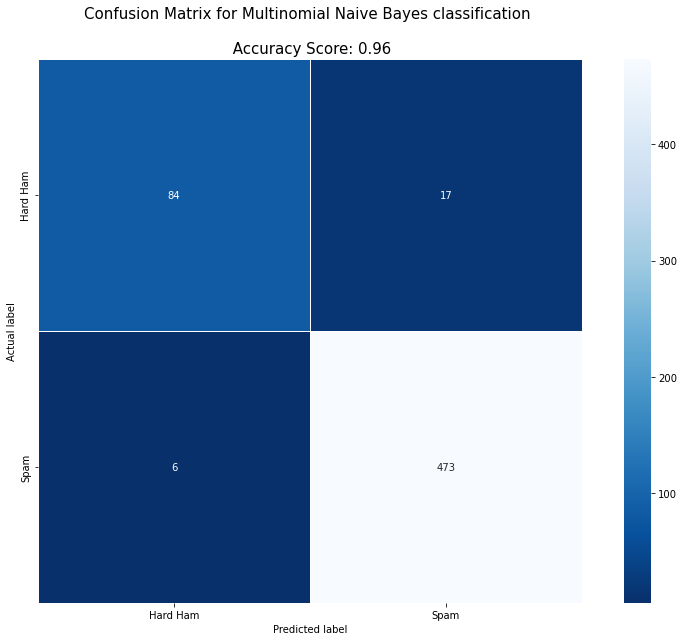

In [31]:
plot_cfm(cfm_hard_mnb_2, acc_hard_mnb_2, "Multinomial Naive Bayes", ["Hard Ham", "Spam"])

In [32]:
print(cr_hard_mnb_2)

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       101
           1       0.97      0.99      0.98       479

    accuracy                           0.96       580
   macro avg       0.95      0.91      0.93       580
weighted avg       0.96      0.96      0.96       580



Multinomial Naive Bayes performs well accuracy wise (0.96) and has both precision and recall close to 1, which is the ideal scenario in the classification of hard ham and spam. This time the accuracy score is closer to the f1-score (or precision/recall) since the dataset is less imbalanced than easy ham and spam.

#### Bernoulli Naive Bayes

In [33]:
acc_hard_bnb_2, cfm_hard_bnb_2, cr_hard_bnb_2 = run_naiveBayes_2(x_hard_spam_train, x_hard_spam_test, y_hard_spam_train, y_hard_spam_test, "BernoulliNB")

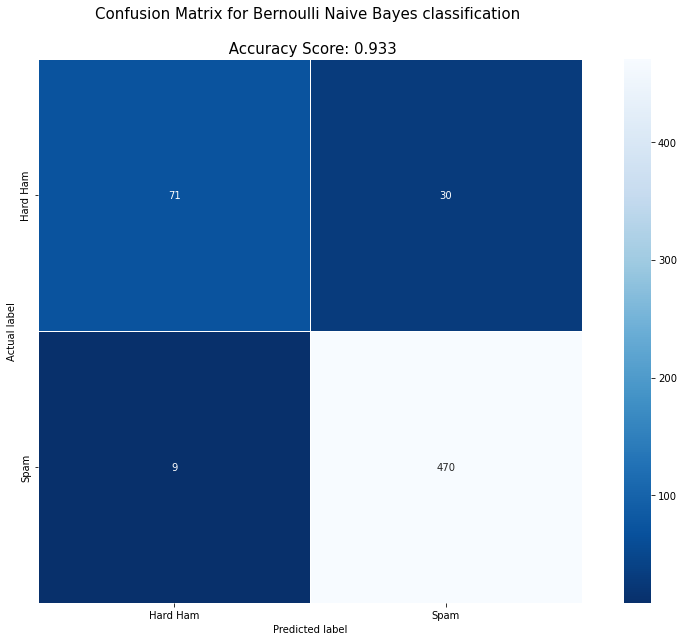

In [34]:
plot_cfm(cfm_hard_bnb_2, acc_hard_bnb_2, "Bernoulli Naive Bayes", ["Hard Ham", "Spam"])

In [35]:
print(cr_hard_bnb_2)

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       101
           1       0.94      0.98      0.96       479

    accuracy                           0.93       580
   macro avg       0.91      0.84      0.87       580
weighted avg       0.93      0.93      0.93       580



Bernoulli NB has an accuracy of 0.93 in hard ham and spam classification. The model has a very high recall and lower precision, meaning it has more false positives, i.e. it misclassifies hard hams as spams.

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax" rowspan="3">Classifier</th>
    <th class="tg-0lax" rowspan="3">Ham Type</th>
    <th class="tg-0lax" colspan="7">Part 4</th>
  </tr>
  <tr>
    <th class="tg-0lax" rowspan="2">accuracy</th>
    <th class="tg-0lax" colspan="2">precision</th>
    <th class="tg-0lax" colspan="2">recall</th>
    <th class="tg-0lax" colspan="2">f1-score</th>
  </tr>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
  </tr>
</thread>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="2">Multinomial Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.97</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.96</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.83</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.88</td>
    <td class="tg-0lax">0.98</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">Bernoulli Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.81</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.98</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.89</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">0.70</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.78</td>
    <td class="tg-0lax">0.96</td>
  </tr>
</tbody>
</table>

Similar to part 3, Multinomial Naive Bayes overall performs better than Bernoulli Naive Bayes in classifying easy ham and hard ham versus spam.

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax" rowspan="3">Classifier</th>
    <th class="tg-0lax" rowspan="3">Ham Type</th>
    <th class="tg-0lax" colspan="7">Part 3</th>
  </tr>
  <tr>
    <th class="tg-0lax" rowspan="2">accuracy</th>
    <th class="tg-0lax" colspan="2">precision</th>
    <th class="tg-0lax" colspan="2">recall</th>
    <th class="tg-0lax" colspan="2">f1-score</th>
  </tr>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="2">Multinomial Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.90</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.95</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.77</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.84</td>
    <td class="tg-0lax">0.97</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">Bernoulli Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.96</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.85</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.92</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.89</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">0.70</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.78</td>
    <td class="tg-0lax">0.96</td>
  </tr>
</tbody>
</table>

When comparing the precision and recall values of the models for the positive class, i.e. spam, we can see that the model improves from parts 3 to 4 for Multinomial Naive Bayes. However, the Bernoulli Naive Bayes model for easy hamps and spams has a slightly worse recall score in part 4 after removing the stopwords.

## 5.	[For higher grades] Filter out the headers and the footers of the emails before you run on them. The format may vary somewhat between emails, which can make this a bit tricky, so perfect filtering is not required. Run your program again and answer the following questions:

    We use this package from python to deal with emails (https://docs.python.org/3/library/email.message.html)

In [36]:
# function to get the body of the email in text by inputing email object
def get_email_body(emailobj):
    # if email is not multipart, return just just regular payload 
    # else return the first text/plain body
    
    if not emailobj.is_multipart():
        return emailobj.get_payload()
    
    for payload in emailobj.get_payload():
        # If the message comes with a signature it can be that this
        # payload itself has multiple parts, so just return the
        # first one
        if payload.is_multipart():
            return get_email_body(payload)
        
        body = payload.get_payload()
        
        if payload.get_content_type() == "text/plain":
            return body

### Easy ham vs spam data

In [37]:
# parse the emails into a list email objects
emails = list(map(email.message_from_string, emails_easy_spam.data))

In [38]:
# extract the body of all emails
body_easy_spam = [get_email_body(msg) for msg in emails]

### Hard ham vs spam data

In [39]:
# parse the emails into a list email objects
emails = list(map(email.message_from_string, emails_hard_spam.data))

In [40]:
# extract the body of all emails
body_hard_spam = [get_email_body(msg) for msg in emails]

When we filter out the headers and footers, we obtain some NoneType objects, hence we convert the filtered data into dataframes along with the targets so that we can drop those rows

In [41]:
# assign data of lists.  
data_easy = {"emails": body_easy_spam, "target": emails_easy_spam.target}  
data_hard = {"emails": body_hard_spam, "target": emails_hard_spam.target}  

# create DataFrame  
df_easy_spam = pd.DataFrame(data_easy)
df_hard_spam = pd.DataFrame(data_hard)

# drop rows with Nan
df_easy_spam.dropna(inplace = True)
df_hard_spam.dropna(inplace = True)

In [42]:
# split the spam and the ham datasets in a training set and a test set.
x_easy_spam_train_filtered, x_easy_spam_test_filtered, y_easy_spam_train_filtered, y_easy_spam_test_filtered = train_test_split(df_easy_spam["emails"], df_easy_spam["target"], test_size = 0.2, random_state = 0)
x_hard_spam_train_filtered, x_hard_spam_test_filtered, y_hard_spam_train_filtered, y_hard_spam_test_filtered = train_test_split(df_hard_spam["emails"], df_hard_spam["target"], test_size = 0.2, random_state = 0)

### i.	Spam versus easy-ham

#### Multinomial Naive Bayes

In [43]:
acc_easy_mnb_3, cfm_easy_mnb_3, cr_easy_mnb_3 = run_naiveBayes(x_easy_spam_train_filtered, x_easy_spam_test_filtered, y_easy_spam_train_filtered, y_easy_spam_test_filtered, "MultinomialNB")

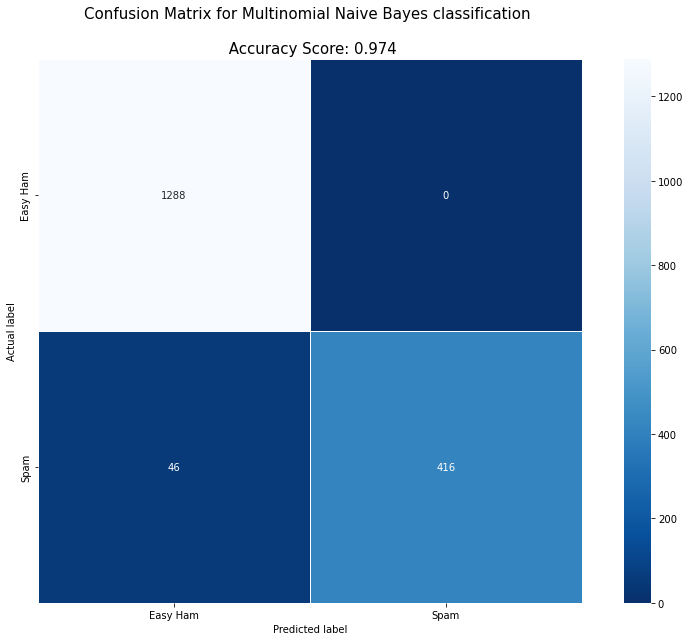

In [44]:
plot_cfm(cfm_easy_mnb_3, acc_easy_mnb_3, "Multinomial Naive Bayes", ["Easy Ham", "Spam"])

In [45]:
print(cr_easy_mnb_3)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1288
           1       1.00      0.90      0.95       462

    accuracy                           0.97      1750
   macro avg       0.98      0.95      0.97      1750
weighted avg       0.97      0.97      0.97      1750



We obtained an accuracy of 0.97 when classifying easy ham and spam using the Multinomial Naive Bayes classifier. Like before we consider the precision and recall for the positive class, i.e. spam. The precision is 1.00, which means it has no false positives i.e. actual hams classified as spams. The model has lower recall which means that it has more false negatives(FN = 46), i.e. spams are misclassified as hams.

#### Bernoulli Naive Bayes

In [46]:
acc_easy_bnb_3, cfm_easy_bnb_3, cr_easy_bnb_3 = run_naiveBayes(x_easy_spam_train_filtered, x_easy_spam_test_filtered, y_easy_spam_train_filtered, y_easy_spam_test_filtered, "BernoulliNB")

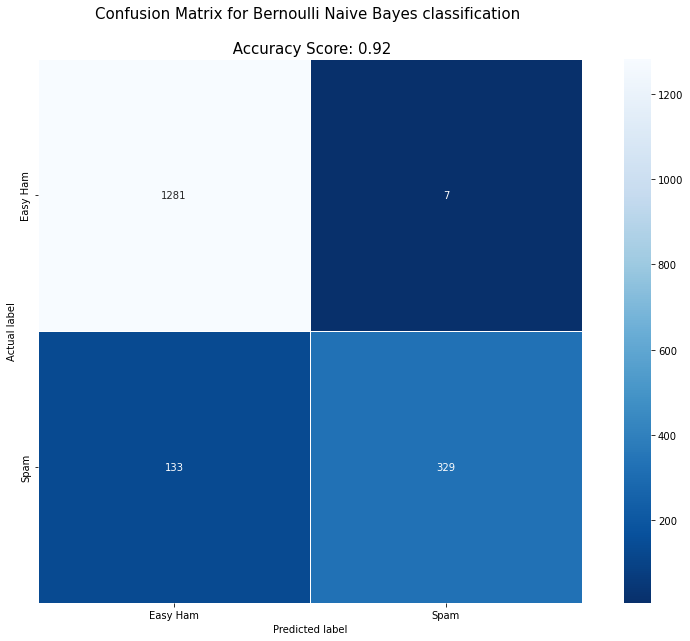

In [47]:
plot_cfm(cfm_easy_bnb_3, acc_easy_bnb_3, "Bernoulli Naive Bayes", ["Easy Ham", "Spam"])

In [48]:
print(cr_easy_bnb_3)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1288
           1       0.98      0.71      0.82       462

    accuracy                           0.92      1750
   macro avg       0.94      0.85      0.89      1750
weighted avg       0.93      0.92      0.92      1750



Despite having a relatively high accuracy (0.92), the Bernoulli NB classifier has a relatively low recall for the positive class, i.e. spam; that is, it has a high number of false-negative (FN = 133), i.e. spams are misclassified as easy hams.

### ii Spam versus hard-ham

#### Multinomial Naive Bayes

In [49]:
acc_hard_mnb_3, cfm_hard_mnb_3, cr_hard_mnb_3 = run_naiveBayes(x_hard_spam_train_filtered, x_hard_spam_test_filtered, y_hard_spam_train_filtered, y_hard_spam_test_filtered, "MultinomialNB")

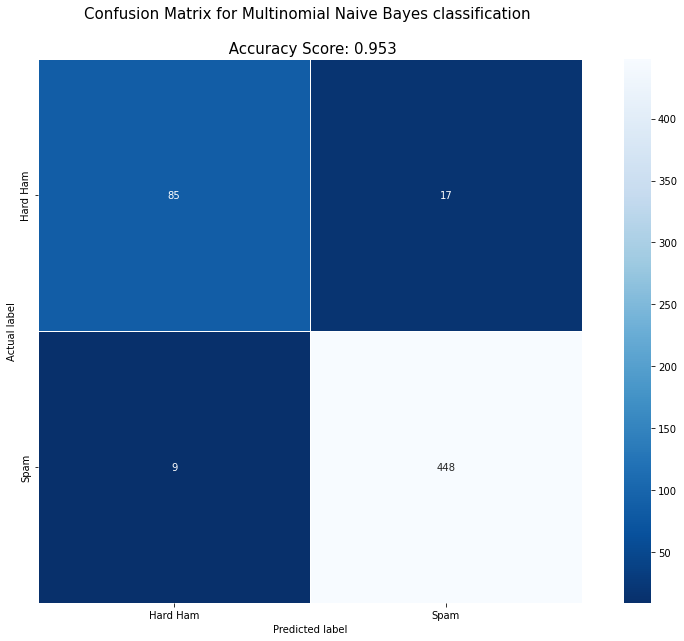

In [50]:
plot_cfm(cfm_hard_mnb_3, acc_hard_mnb_3, "Multinomial Naive Bayes", ["Hard Ham", "Spam"])

In [51]:
print(cr_hard_mnb_3)

              precision    recall  f1-score   support

           0       0.90      0.83      0.87       102
           1       0.96      0.98      0.97       457

    accuracy                           0.95       559
   macro avg       0.93      0.91      0.92       559
weighted avg       0.95      0.95      0.95       559



Multinomial Naive Bayes performs well accuracy wise(0.95) and has both precision and recall close to 1, which is the ideal scenario in the classification of hard ham and spam. As seen before since the dataset is less imbalanced than easy ham and spam, the accuracy score is closer to the f1-score (or precision/recall) .

#### Bernoulli Naive Bayes

In [52]:
acc_hard_bnb_3, cfm_hard_bnb_3, cr_hard_bnb_3 = run_naiveBayes(x_hard_spam_train_filtered, x_hard_spam_test_filtered, y_hard_spam_train_filtered, y_hard_spam_test_filtered,"BernoulliNB")

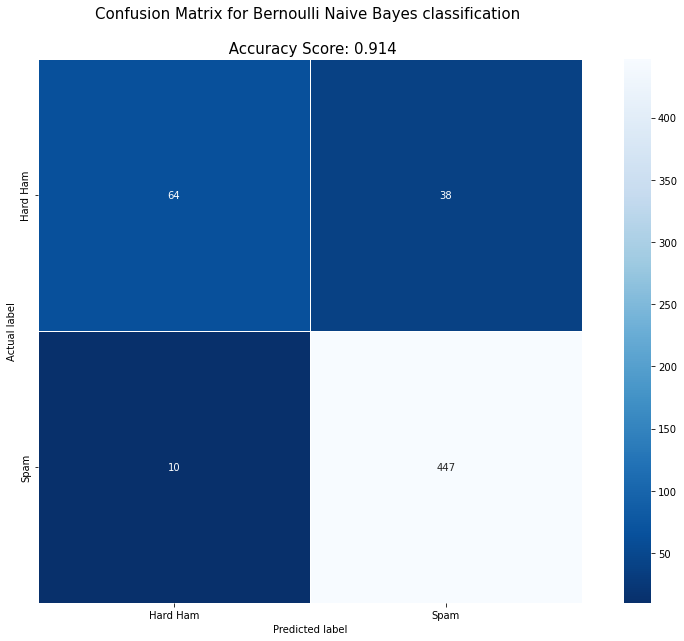

In [53]:
plot_cfm(cfm_hard_bnb_3, acc_hard_bnb_3, "Bernoulli Naive Bayes", ["Hard Ham", "Spam"])

In [54]:
print(cr_hard_bnb_3)

              precision    recall  f1-score   support

           0       0.86      0.63      0.73       102
           1       0.92      0.98      0.95       457

    accuracy                           0.91       559
   macro avg       0.89      0.80      0.84       559
weighted avg       0.91      0.91      0.91       559



Bernoulli NB has an accuracy of 0.91 in hard ham and spam classification. The model has a very high recall and lower precision, meaning it has more false positives, i.e. it misclassifies hard hams as spams. 

Again, overall, Multinomial Naive Bayes performs better than  Bernoulli Naive Bayes in classifying easy ham and hard ham versus spam.

### a. Does the result improve from 3 and 4?

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax" rowspan="3">Classifier</th>
    <th class="tg-0lax" rowspan="3">Ham Type</th>
    <th class="tg-0lax" colspan="7">Part 3</th>
  </tr>
  <tr>
    <th class="tg-0lax" rowspan="2">accuracy</th>
    <th class="tg-0lax" colspan="2">precision</th>
    <th class="tg-0lax" colspan="2">recall</th>
    <th class="tg-0lax" colspan="2">f1-score</th>
  </tr>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="2">Multinomial Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.90</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.95</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.77</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.84</td>
    <td class="tg-0lax">0.97</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">Bernoulli Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.96</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.85</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.92</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.89</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">0.70</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.78</td>
    <td class="tg-0lax">0.96</td>
  </tr>
</tbody>
</table>

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax" rowspan="3">Classifier</th>
    <th class="tg-0lax" rowspan="3">Ham Type</th>
    <th class="tg-0lax" colspan="7">Part 4</th>
  </tr>
  <tr>
    <th class="tg-0lax" rowspan="2">accuracy</th>
    <th class="tg-0lax" colspan="2">precision</th>
    <th class="tg-0lax" colspan="2">recall</th>
    <th class="tg-0lax" colspan="2">f1-score</th>
  </tr>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
  </tr>
</thread>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="2">Multinomial Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.97</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.96</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.83</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.88</td>
    <td class="tg-0lax">0.98</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">Bernoulli Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.81</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.98</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.93</td>
    <td class="tg-0lax">0.89</td>
    <td class="tg-0lax">0.94</td>
    <td class="tg-0lax">0.70</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.78</td>
    <td class="tg-0lax">0.96</td>
  </tr>
</tbody>
</table>

<table>
<thread>
<tr>
    <th class="tg-0lax" rowspan="3">Classifier</th>
    <th class="tg-0lax" rowspan="3">Ham Type</th>
    <th class="tg-0lax" colspan="7">Part 5</th>
  </tr>
  <tr>
    <th class="tg-0lax" rowspan="2">accuracy</th>
    <th class="tg-0lax" colspan="2">precision</th>
    <th class="tg-0lax" colspan="2">recall</th>
    <th class="tg-0lax" colspan="2">f1-score</th>
  </tr>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax">1</th>
  </tr>
<thread>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="2">Multinomial Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">0.97</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">1.00</td>
    <td class="tg-0lax">0.90</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.95</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.90</td>
    <td class="tg-0lax">0.96</td>
    <td class="tg-0lax">0.83</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.87</td>
    <td class="tg-0lax">0.97</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">Bernoulli Naive Bayes</td>
    <td class="tg-0lax">Easy</td>
    <td class="tg-0lax">0.92</td>
    <td class="tg-0lax">0.91</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.99</td>
    <td class="tg-0lax">0.71</td>
    <td class="tg-0lax">0.95</td>
    <td class="tg-0lax">0.82</td>
  </tr>
  <tr>
    <td class="tg-0lax">Hard</td>
    <td class="tg-0lax">0.91</td>
    <td class="tg-0lax">0.86</td>
    <td class="tg-0lax">0.92</td>
    <td class="tg-0lax">0.63</td>
    <td class="tg-0lax">0.98</td>
    <td class="tg-0lax">0.73</td>
    <td class="tg-0lax">0.95</td>
  </tr>
</tbody>
</table>

By comparing the precision and recall for the positive class, i.e. spam, we can see that the models have reduced for both Multinominal Naive Bayes and Bernoulli Naive Bayes classifiers. By extracting the email body, we can see that the header and footer of the emails did have some necessary information to help classify the email as spam or ham.

### b. The split of the data set into a training set and a test set can lead to very skewed results. Why is this, and do you have suggestions on remedies?

Our training dataset is imbalanced, and most of the data is from the ham class. The class distribution is skewed, so most machine learning algorithms will perform poorly and require modification to avoid simply predicting the majority class in all cases.

For instance, in our dataset, we consider spam and ham emails. The training dataset consists mainly of ham emails, and the model might be more inclined to predict ham since there are more ham emails than spam emails. 

There are many ways to handle imbalanced datasets; below are a few suggestions :

* Using SMOTE(Synthetic Minority Oversampling Technique) generates synthetic samples for your imbalanced text data.  
* Balancing the data with Oversampling techniques or undersampling the majority class.
* Use the stratified parameters when splitting the training and test set so that the output has a balanced distribution
* Assign class_weights as a parameter to the model's fit method, for instance, increasing weights of minority classes.

### c.	What do you expect would happen if your training set were mostly spam messages while your test set were mostly ham messages?

The class distribution would again be imbalanced. However, this time, the results will be more skewed towards the opposite direction (more likely to predict spam rather than ham), i.e. there would be many more false positives where hams will be classified as spams.